In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 21.2 MB/s eta 0:00:00


In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from rdkit.Chem import MACCSkeys
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
canvas_width_pixels = 300
canvas_height_pixels  = 300

In [ ]:
input_smiles = 'C[N+](C)(C)CCO.[Cl-]'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('choline_chloride.svg', 'w') as f:
    f.write(svg)

In [ ]:
input_smiles = 'C(=O)(N)N'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('urea.svg', 'w') as f:
    f.write(svg)

In [ ]:
df = pd.read_csv('data_cleaned.csv')
df.columns

Index(['DES', 'T (K)', 'P (kPa)', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       'ln(x)-experimental', 'Split', 'ln(x)-ANN-Mohan', 'DES name', 'r HBA', 'r HBD', 'HBA name',
       'HBD name', 'DES standarized name'],
      dtype='object')

In [ ]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Auto-adjust width to display all columns

In [ ]:
df['HBA_HBD'] = df['HBA name'] + '_' + df['HBD name']


# Display DataFrame
df['HBA_HBD'].value_counts()

Betain_1,2-propanediol      100
[ACh]Cl_Imidazole            98
[Ch]Cl_Phenol                74
[Ch]Cl_FA                    72
[Ch]Cl_LEV                   72
[Ch]Cl_Guaiacol              72
[DEA]Cl_Guaiacol             72
[ACh]Cl_Guaiacol             72
[TBA]Br_HEXA                 63
[Ch]Cl_DEG                   53
Betain_DEG                   50
[Ch]Cl_EG                    45
[TOA]Cl_DECA                 45
[TEA]Br_HEXA                 42
[TEA]Cl_LA                   40
[TMA]Cl_LA                   40
[Ch]Cl_1,2-propanediol       40
[Ch]Cl_2,3-butanediol        40
[Ch]Cl_1,4-butanediol        40
[Ch]Cl_TEG                   40
[ATPP]Br_Phenol              36
[TBA]Cl_DECA                 36
[Ch]Cl_Urea                  36
[TBA]Br_MDA                  29
[TEA]Cl_LEV                  28
[TEA]Br_LEV                  28
[Ch]Cl_1,2-butanediol        28
[TBA]Cl_LEV                  28
[ACh]Cl_LEV                  28
[ACh]Cl_1,2,4-triazole       28
[TBA]Cl_LA                   28
[TOMA]Br

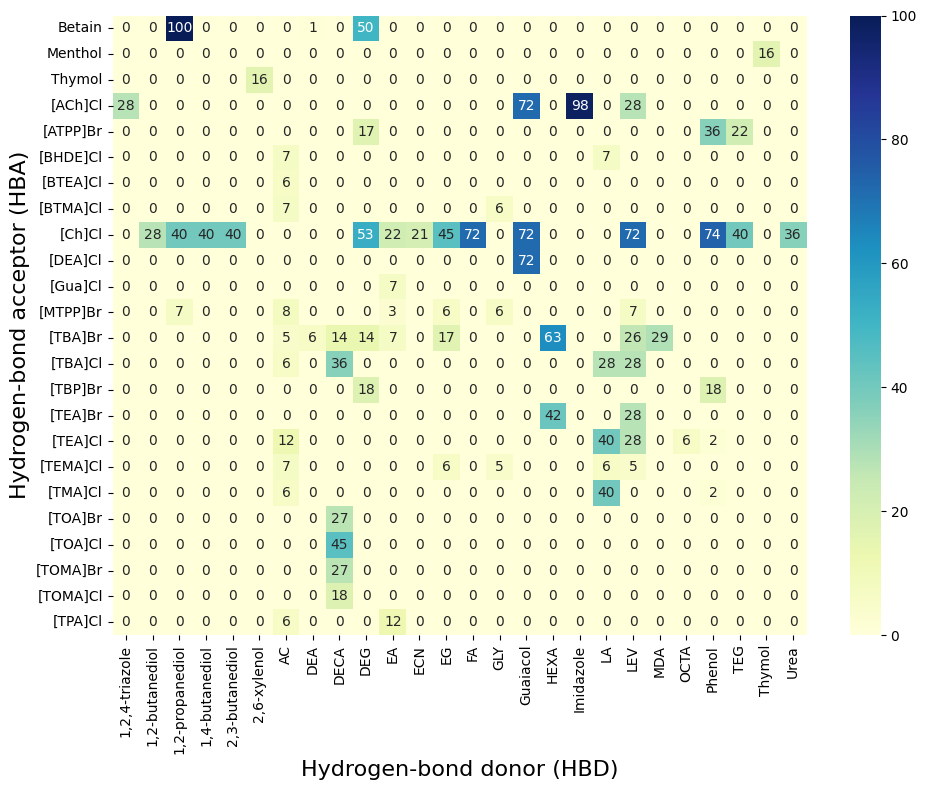

In [ ]:
heatmap_data = df.groupby(['HBA name', 'HBD name']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')
plt.ylabel('Hydrogen-bond acceptor (HBA)', fontsize=16)
plt.xlabel('Hydrogen-bond donor (HBD)', fontsize=16)
plt.tight_layout()
plt.savefig('heatmap_counting.png', dpi=300)
plt.show()

In [ ]:
df_hba = pd.read_csv('HBA_smiles.csv')
df_hbd = pd.read_csv('HBD_smiles.csv')

In [ ]:
def get_fingerprint(df, type_fingerprint):
    mols = df['SMILES'].apply(Chem.MolFromSmiles).tolist()
    fgps = []

    for mol in mols:
      if type_fingerprint == 'MACCS':
        fgp = MACCSkeys.GenMACCSKeys(mol)
        fgp = np.array([int(bit) for bit in fgp.ToBitString()], dtype=int)[1:] # position 0 is always ignored
      elif type_fingerprint == 'ECFP':
        fgp = GetMorganFingerprintAsBitVect(mol, 4, 2048, bitInfo={})
      fgps.append(fgp)
    df[type_fingerprint] = fgps
    return df

In [ ]:
df_hba = get_fingerprint(df_hba, 'ECFP')
df_hbd = get_fingerprint(df_hbd, 'ECFP')

In [ ]:
df['HBA_fp'] = df['HBA name'].map(df_hba.set_index('Short')['ECFP'])
df['HBD_fp'] = df['HBD name'].map(df_hbd.set_index('Short')['ECFP'])

In [ ]:
X = df.loc[:, ['T (K)','P (kPa)','r HBA', 'r HBD']].to_numpy()

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
# Combine fingerprints, temperature, presure and composition into a single array
descriptors = []
for i, row in df.iterrows():
    hba_fp = row['HBA_fp']
    hbd_fp = row['HBD_fp']
    concatenated_fp = np.concatenate([hba_fp, hbd_fp])#, X_norm[i]])
    descriptors.append(concatenated_fp)
descriptors = np.array(descriptors)

In [ ]:
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
descriptors_tsne = tsne.fit_transform(descriptors)

In [ ]:
df_tsne = pd.DataFrame({
    'HBA name':df['HBA name'].tolist(),
    'HBD name':df['HBD name'].tolist(),
    'tsne_1':descriptors_tsne[:, 0],
    'tsne_2':descriptors_tsne[:, 1],
    'CO2_sol':df['ln(x)-experimental'].tolist()
})
df_tsne.to_csv('tsne.csv', index=False)

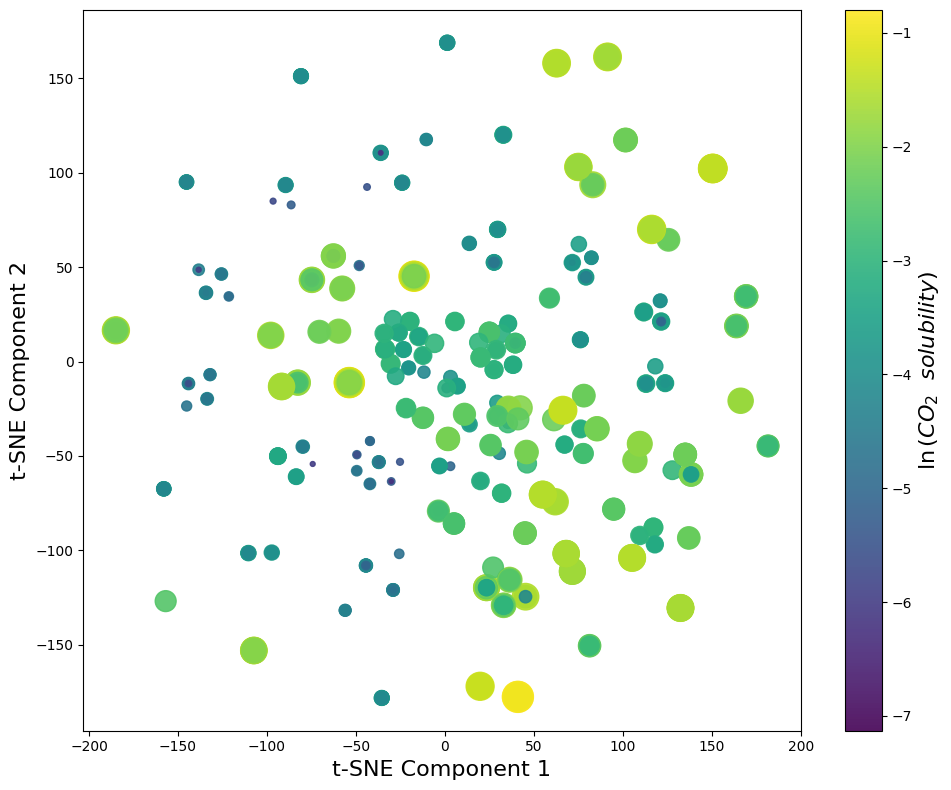

In [ ]:
# Plot the t-SNE visualization
# Apply a non-linear transformation to CO2_sol values to amplify the differences
size_factor = (df_tsne['CO2_sol'] - df_tsne['CO2_sol'].min() + 1) ** 3
size_factor /= size_factor.max()  # Normalize to range [0, 1]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['CO2_sol'], cmap='viridis', alpha=0.9, s=size_factor*500)
plt.xlabel('t-SNE Component 1', fontsize=16)
plt.ylabel('t-SNE Component 2', fontsize=16)
colorbar  = plt.colorbar(scatter, label='$\ln{(CO_2 ~~ solubility)}$')  # Add color bar
colorbar.ax.yaxis.label.set_fontsize(16)
plt.tight_layout()
plt.savefig('tsne.png', dpi=300)
plt.show()

In [ ]:
input_smiles = 'C=CC[P+](c1ccccc1)(c1ccccc1)c1ccccc1.[Br-]'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('[ATPP]Br.svg', 'w') as f:
    f.write(svg)

In [ ]:
input_smiles = 'OCCOCCOCCO'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('TEG.svg', 'w') as f:
    f.write(svg)

In [ ]:
input_smiles = 'CC(=O)OCC[N+](C)(C)C.[Cl-]'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('[ACh]Cl.svg', 'w') as f:
    f.write(svg)

In [ ]:
input_smiles = 'c1c[nH]cn1'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('Imidazole.svg', 'w') as f:
    f.write(svg)

In [ ]:
input_smiles = 'OCCO'
mol = MolFromSmiles(input_smiles)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(canvas_width_pixels,canvas_height_pixels)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()

with open('EG.svg', 'w') as f:
    f.write(svg)